In [2]:
import pandas as pd

indicator_metadata = pd.DataFrame([
    {
        "indicator_id": "co2_per_capita_log",
        "name": "Log CO₂ emissions per capita",
        "description": "Log(1 + territorial CO₂ emissions per person). Main outcome of interest in the regression models."
    },
    {
        "indicator_id": "gni_pc_log",
        "name": "Log gross national income per capita",
        "description": "Log(1 + gross national income per person, adjusted for purchasing power). Captures income level and overall economic development."
    },
    {
        "indicator_id": "mys",
        "name": "Mean years of schooling",
        "description": "Average number of completed years of education for adults aged 25 and older. Proxy for educational attainment and human capital."
    },
    {
        "indicator_id": "life_expectancy",
        "name": "Life expectancy at birth",
        "description": "Average number of years a newborn is expected to live given current age-specific mortality rates. Summary indicator of health and survival."
    },
    {
        "indicator_id": "under5_mortality_log",
        "name": "Log under-five mortality rate",
        "description": "Log(1 + under-five mortality per 1,000 live births). Measures early-childhood mortality and health system performance."
    },
    {
        "indicator_id": "electricity_access_pct",
        "name": "Access to electricity (% of population)",
        "description": "Share of the population with access to electricity from any source. Indicator of infrastructure and basic services."
    },
    {
        "indicator_id": "renewable_energy_pct",
        "name": "Renewable energy share (% of final energy)",
        "description": "Share of renewables in total final energy consumption, including hydro, solar, wind and modern bioenergy. Proxy for the sustainability of the energy mix."
    },
    {
        "indicator_id": "urban_population_pct",
        "name": "Urban population share (% of total)",
        "description": "Share of the total population living in urban areas. Proxy for urbanisation and structural change."
    },
    {
        "indicator_id": "population_growth_pct",
        "name": "Population growth rate (% per year)",
        "description": "Annual percentage growth of the resident population. Captures demographic dynamics and expansion."
    },
])

indicator_metadata

,indicator_id,name,description
0,co2_per_capita_log,Log CO₂ emissions per capita,Log(1 + territorial CO₂ emissions per person)....
1,gni_pc_log,Log gross national income per capita,"Log(1 + gross national income per person, adju..."
2,mys,Mean years of schooling,Average number of completed years of education...
3,life_expectancy,Life expectancy at birth,Average number of years a newborn is expected ...
4,under5_mortality_log,Log under-five mortality rate,"Log(1 + under-five mortality per 1,000 live bi..."
5,electricity_access_pct,Access to electricity (% of population),Share of the population with access to electri...
6,renewable_energy_pct,Renewable energy share (% of final energy),Share of renewables in total final energy cons...
7,urban_population_pct,Urban population share (% of total),Share of the total population living in urban ...
8,population_growth_pct,Population growth rate (% per year),Annual percentage growth of the resident popul...


In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors

# Load a compact sentence embedding model
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


/Users/mnn/miniforge3/envs/ds-text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Combine name + description into one text field
texts = (indicator_metadata["name"] + ". " + indicator_metadata["description"]).tolist()

# Compute embeddings
embeddings = embed_model.encode(
    texts, 
    show_progress_bar=True, 
    normalize_embeddings=True)

# Build a nearest-neighbour index (cosine distance)
nn_index = NearestNeighbors(n_neighbors=5, metric="cosine")
nn_index.fit(embeddings)

embeddings.shape

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


(9, 384)

In [5]:
import numpy as np

def search_indicators(query, top_k=5):
    """
    Semantic search over indicator names + descriptions.
    Returns the top_k most similar indicators to the query string.
    """
    # Encode the query
    q_emb = embed_model.encode([query], normalize_embeddings=True)
    
    # Find nearest neighbours
    distances, indices = nn_index.kneighbors(q_emb, n_neighbors=top_k)
    
    # Convert cosine distance to similarity
    sims = 1 - distances[0]
    
    # Build result table
    results = indicator_metadata.iloc[indices[0]].copy()
    results["similarity"] = sims
    results = results.sort_values("similarity", ascending=False)
    
    return results[["indicator_id", "name", "description", "similarity"]]

In [6]:
display(search_indicators("education and human capital", top_k=5))

display(search_indicators("child health and mortality", top_k=3))

display(search_indicators("renewable energy and climate mitigation", top_k=2))

display(search_indicators("urbanisation and infrastructure", top_k=1))

,indicator_id,name,description,similarity
2,mys,Mean years of schooling,Average number of completed years of education...,0.505675
8,population_growth_pct,Population growth rate (% per year),Annual percentage growth of the resident popul...,0.218668
7,urban_population_pct,Urban population share (% of total),Share of the total population living in urban ...,0.211225
0,co2_per_capita_log,Log CO₂ emissions per capita,Log(1 + territorial CO₂ emissions per person)....,0.179847
1,gni_pc_log,Log gross national income per capita,"Log(1 + gross national income per person, adju...",0.146217


,indicator_id,name,description,similarity
4,under5_mortality_log,Log under-five mortality rate,"Log(1 + under-five mortality per 1,000 live bi...",0.609265
3,life_expectancy,Life expectancy at birth,Average number of years a newborn is expected ...,0.487517
8,population_growth_pct,Population growth rate (% per year),Annual percentage growth of the resident popul...,0.280031


,indicator_id,name,description,similarity
6,renewable_energy_pct,Renewable energy share (% of final energy),Share of renewables in total final energy cons...,0.533677
0,co2_per_capita_log,Log CO₂ emissions per capita,Log(1 + territorial CO₂ emissions per person)....,0.302970


,indicator_id,name,description,similarity
7,urban_population_pct,Urban population share (% of total),Share of the total population living in urban ...,0.4944


### Semantic search over sustainability indicators

To support indicator discovery and organisation, a small semantic search tool was built for the variables used in the CO₂–development analysis. For each indicator, a short metadata record was defined with:

- an identifier (e.g. `gni_pc_log`, `renewable_energy_pct`),
- a human-readable name,
- and a short description.

The names and descriptions were embedded using a pre-trained sentence-transformer model (`all-MiniLM-L6-v2`). A k-nearest neighbour index with cosine distance was then fitted on these embeddings. Given a free-text query (for example, “education and human capital”, “child health and mortality”, or “renewable energy and climate mitigation”), the system:

1. encodes the query into the same embedding space,
2. retrieves the most similar indicator descriptions,
3. and returns a ranked list with similarity scores.

The retrieved results show that the tool correctly surfaces education, health, energy and urbanisation indicators for relevant queries. This demonstrates how transformer-based embeddings and vector search can support AI-assisted exploration of sustainability indicators, complementing manual selection and keyword search in evidence synthesis workflows.

In [7]:
indicator_metadata["theme"] = [
    "Emissions & energy",      # co2_per_capita_log
    "Human development",       # gni_pc_log
    "Human development",       # mys
    "Human development",       # life_expectancy
    "Human development",       # under5_mortality_log
    "Infrastructure & access", # electricity_access_pct
    "Emissions & energy",      # renewable_energy_pct
    "Urbanisation",            # urban_population_pct
    "Demography",              # population_growth_pct
]

indicator_metadata

,indicator_id,name,description,theme
0,co2_per_capita_log,Log CO₂ emissions per capita,Log(1 + territorial CO₂ emissions per person)....,Emissions & energy
1,gni_pc_log,Log gross national income per capita,"Log(1 + gross national income per person, adju...",Human development
2,mys,Mean years of schooling,Average number of completed years of education...,Human development
3,life_expectancy,Life expectancy at birth,Average number of years a newborn is expected ...,Human development
4,under5_mortality_log,Log under-five mortality rate,"Log(1 + under-five mortality per 1,000 live bi...",Human development
5,electricity_access_pct,Access to electricity (% of population),Share of the population with access to electri...,Infrastructure & access
6,renewable_energy_pct,Renewable energy share (% of final energy),Share of renewables in total final energy cons...,Emissions & energy
7,urban_population_pct,Urban population share (% of total),Share of the total population living in urban ...,Urbanisation
8,population_growth_pct,Population growth rate (% per year),Annual percentage growth of the resident popul...,Demography


In [8]:
import networkx as nx

G = nx.Graph()

for _, row in indicator_metadata.iterrows():
    ind_id = row["indicator_id"]
    theme = row["theme"]
    
    # Indicator node
    G.add_node(ind_id, type="indicator", name=row["name"])
    
    # Theme node
    G.add_node(theme, type="theme")
    
    # Edge between indicator and theme
    G.add_edge(ind_id, theme)

In [9]:
def indicators_for_theme(theme_name):
    return [
        n for n in G.neighbors(theme_name)
        if G.nodes[n].get("type") == "indicator"
    ]

print("Indicators linked to 'Emissions & energy':")
print(indicators_for_theme("Emissions & energy"))

print("\nIndicators linked to 'Human development':")
print(indicators_for_theme("Human development"))


Indicators linked to 'Emissions & energy':
['co2_per_capita_log', 'renewable_energy_pct']

Indicators linked to 'Human development':
['gni_pc_log', 'mys', 'life_expectancy', 'under5_mortality_log']


In [10]:
def themes_for_keyword(keyword):
    keyword = keyword.lower()
    matched_inds = [
        n for n, data in G.nodes(data=True)
        if data.get("type") == "indicator"
        and keyword in data.get("name", "").lower()
    ]
    themes = set()
    for ind in matched_inds:
        for neigh in G.neighbors(ind):
            if G.nodes[neigh].get("type") == "theme":
                themes.add(neigh)
    return matched_inds, sorted(themes)

inds, themes = themes_for_keyword("mortality")
print("Indicators containing 'mortality':", inds)
print("Themes linked to these indicators:", themes)


Indicators containing 'mortality': ['under5_mortality_log']
Themes linked to these indicators: ['Human development']


/var/folders/hv/mm029zcj2j1cm_qjq29d9b8c0000gn/T/ipykernel_97342/311323874.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


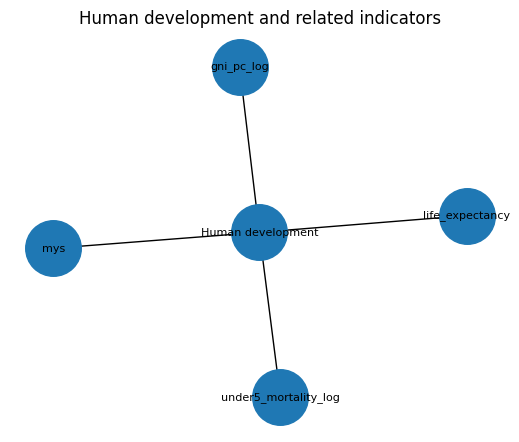

In [11]:
import matplotlib.pyplot as plt

sub_nodes = ["Human development"] + indicators_for_theme("Human development")
H = G.subgraph(sub_nodes)

plt.figure(figsize=(5, 4))
pos = nx.spring_layout(H, seed=42)
nx.draw(H, pos, with_labels=True, node_size=1600, font_size=8)
plt.title("Human development and related indicators")
plt.tight_layout()
plt.show()


### Simple graph representation of indicators and themes

To illustrate a basic knowledge-graph representation, the indicator metadata were converted into a small graph using NetworkX:

- Each indicator is represented as a node with attributes (identifier and name).
- Each indicator is linked to a broader thematic node such as “Emissions & energy”, “Human development”, “Infrastructure & access”, “Urbanisation” or “Demography”.
- Edges connect indicators to their themes, so that themes collect the indicators that belong to them.

This structure enables simple but useful queries, for example:

- retrieving all indicators associated with a given theme (e.g. all indicators under “Emissions & energy”),
- identifying which themes are linked to indicators whose names contain a given keyword (e.g. indicators containing “mortality”),
- and visualising subgraphs for specific themes, such as “Emissions & energy” and its related indicators.

Although minimal, this graph demonstrates how sustainability indicators and their relationships can be organised in a way that supports querying and exploration, complementing the tabular dataset and the semantic-search view of the same information.